In [342]:
import pandas as pd, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, calendar, time
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.ticker
%matplotlib inline

In [343]:
PLACE = "haiti"

Read in the versions file

In [344]:
header = ['id','type','amenity','highway','building','name','length','area','aA','aD','aM','user', 'version','minorVersion','validSince','validUntil','changeset','center']

In [345]:
df = pd.read_csv('../data/'+PLACE+'-all-stats.data',names=header, sep='\t',index_col=None)
df.sort_values(by='validSince',inplace=True)
df = df.reset_index(drop=True)
df.head(2)

,id,type,amenity,highway,building,name,length,area,aA,aD,aM,user,version,minorVersion,validSince,validUntil,changeset,center
0,22871332,way,NaN,NaN,NaN,NaN,3.056892,NaN,aeroway-->runway|-|created_by-->Potlatch 0.7,NaN,NaN,dcjc,1,0.0,1202173954,1202173990,42286,"-72.29258585,18.58"
1,22871332,way,NaN,NaN,NaN,NaN,3.056892,NaN,NaN,NaN,NaN,dcjc,2,0.0,1202173990,1208630086,42286,"-72.29258585,18.58"


Calculate new columns and convert to Python objects

In [346]:
df['date'] = df.validSince.apply(lambda x: pd.Timestamp(x*1000000000).date())
df.replace("false", np.NaN, inplace=True)
df.validUntil = df['validUntil'].astype(float)

In [347]:
df.id.count(), df.id.nunique(), df.user.nunique(), df.query('version==1').id.nunique()

(481694, 138612, 3677, 133695)

In [348]:
#Cast length and area to floats
df.length = pd.to_numeric(df.length, downcast='float')
df.area = pd.to_numeric(df.length, downcast='float')
df.version = pd.to_numeric(df.version, downcast='integer')

# 1. Kilometers of roads overtime

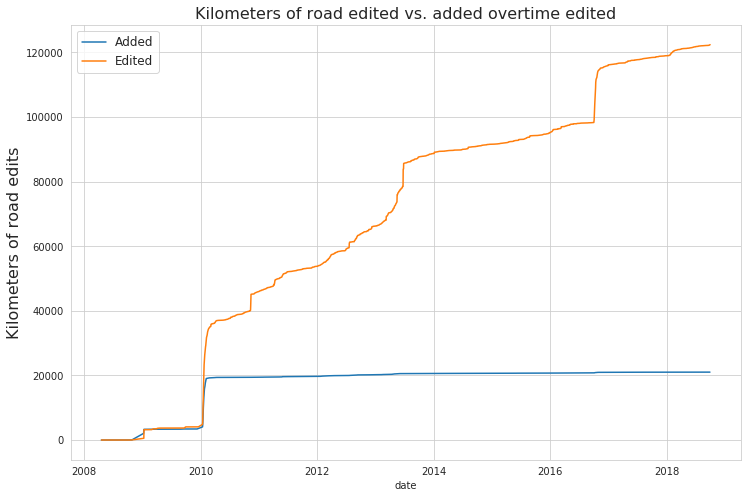

In [349]:
sns.set_style('whitegrid')
hw = df[~pd.isnull(df.highway)]
ax = hw[hw.version==1].groupby('date').aggregate({'length':sum}).cumsum().plot(figsize=(12,8),legend=None)
hw[hw.version>1].groupby('date').aggregate({'length':sum}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Kilometers of road edits",fontsize=16)
ax.set_title("Kilometers of road edited vs. added overtime edited",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

Text(0.5, 1.0, 'Highway KM edited per changeset')

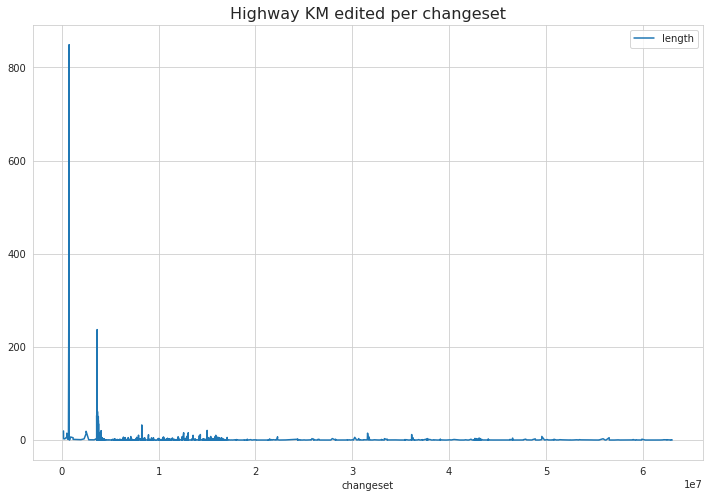

In [350]:
ax = hw[hw.version==1].groupby('changeset').aggregate({'length':sum}).plot(figsize=(12,8))
ax.set_title('Highway KM edited per changeset',fontsize=16)

# 2 Buildings Overtime

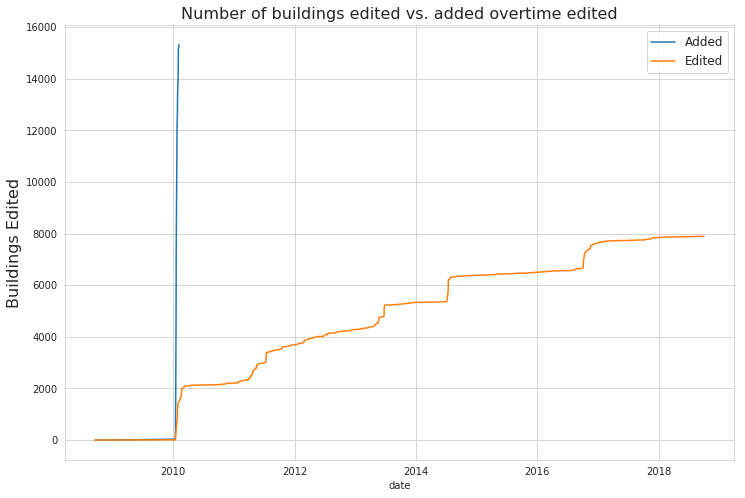

In [351]:
sns.set_style('whitegrid')
buildings = df[~pd.isnull(df.building)]
ax = buildings[(buildings.version==1) & (buildings.minorVersion==0)].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(figsize=(12,8),legend=None)
buildings[buildings.version>1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Buildings Edited",fontsize=16)
ax.set_title("Number of buildings edited vs. added overtime edited",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

### Top Building Contributors (Added)

In [352]:
buildings[(buildings.minorVersion==0) & (buildings.version==1)].groupby('user').aggregate({'id':'count'}).sort_values(by='id',ascending=False).head(10)


,id
user,
rab,2098
Paul The Archivist,2051
hadhuey,1646
dbusse,1218
alv,876
guggis,816
XBear,766
om3g4,557
bass,488


### Top Building Contributors (Added Last Month)

In [353]:
buildings[(buildings.minorVersion==0) & (buildings.version==1) & (buildings.date > datetime.date(2018,9,1))].groupby('user').aggregate({'id':'count'}).sort_values(by='id',ascending=False).head(10)


,id
user,


# 3 Amenities Overtime

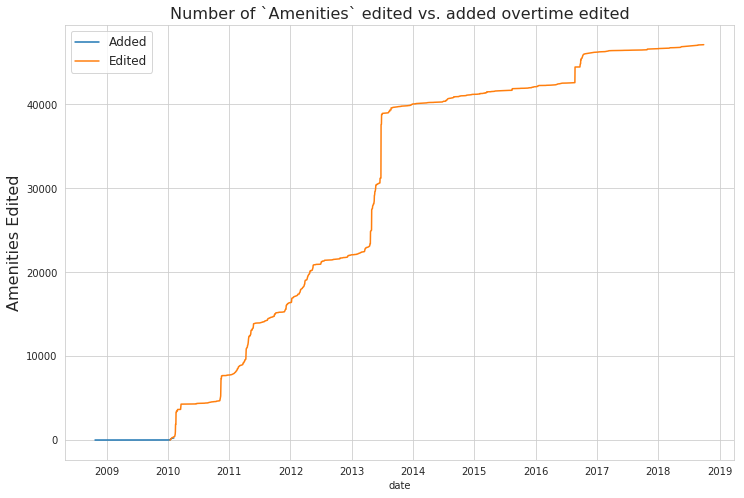

In [354]:
sns.set_style('whitegrid')
amenities = df[~pd.isnull(df.amenity)]
ax = amenities[(amenities.version==1) & (amenities.minorVersion==0)].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(figsize=(12,8),legend=None)
amenities[amenities.version>1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Amenities Edited",fontsize=16)
ax.set_title("Number of `Amenities` edited vs. added overtime edited",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

# 4 Contributors per week ... an editing pulse?

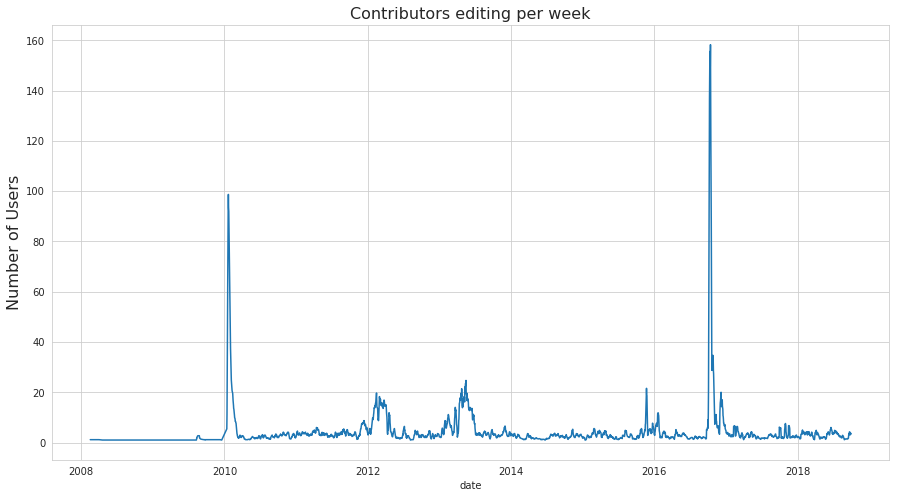

In [355]:
ax = df.groupby('date').aggregate({'user':'nunique'}).rolling(7).mean().plot(figsize=(15,8),legend=None)
ax.set_ylabel("Number of Users",fontsize=16)
ax.set_title("Contributors editing per week",fontsize=16);

# 5 Edits per week?

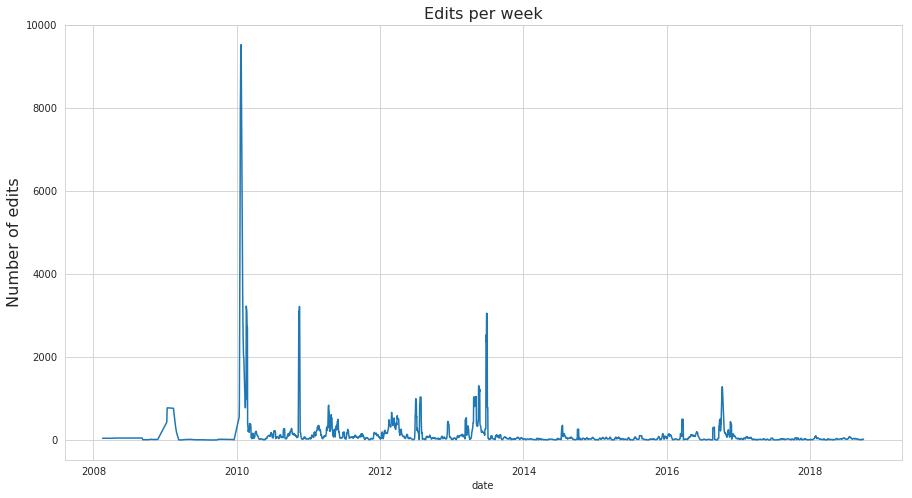

In [356]:
ax = df.groupby('date').aggregate({'id':'count'}).rolling(7).mean().plot(figsize=(15,8),legend=None)
ax.set_ylabel("Number of edits",fontsize=16)
ax.set_title("Edits per week",fontsize=16);

# 6 Users overtime

In [304]:
unique_users_over_time = df.groupby('user').aggregate({'date':min}).reset_index().groupby('date').aggregate({'user':'count'})

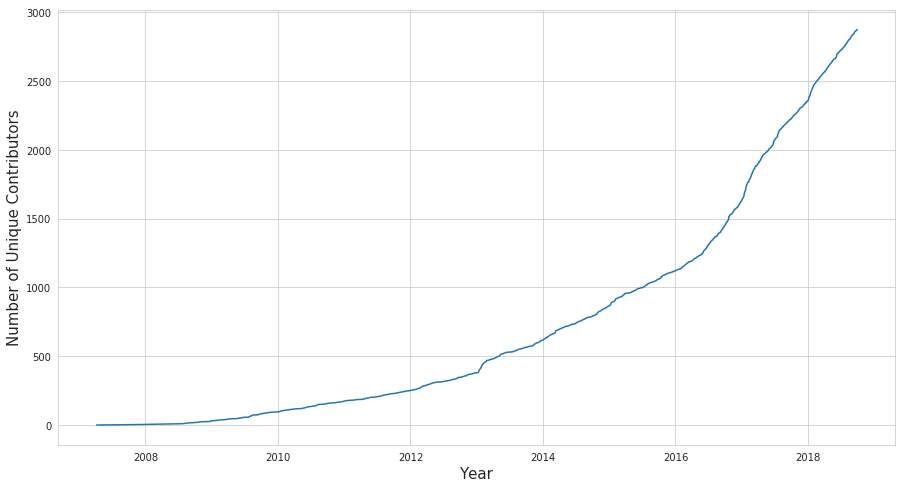

In [305]:
sns.set_style('whitegrid')
ax = unique_users_over_time.cumsum().plot(figsize=(15,8),legend=None)
ax.set_ylabel('Number of Unique Contributors', fontsize=15);
ax.set_xlabel('Year', fontsize=15);

# 7 Contributor Co-Editing Network

In [248]:
import networkx as nx

In [249]:
G = nx.DiGraph()
for line in open('../data/'+PLACE+'-users.edgelist','r'):
    sourceLabel, targetLabel, weight = line.split(",")
    weight = int(weight)
    if weight > 100:
        G.add_edge(sourceLabel, targetLabel, weight=weight)

In [250]:
len(G.nodes())

132

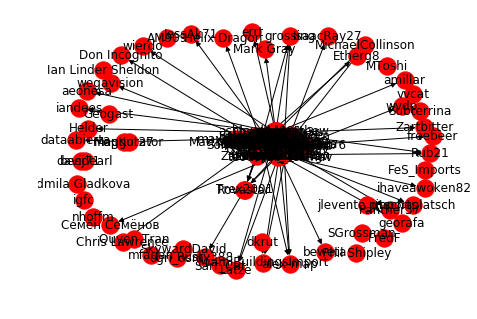

In [251]:
nx.draw_spring(G, figsize=(15,8), with_labels=True)

In [252]:
nx.write_graphml(G,'/data/www/'+PLACE+'.graphml');
print("Download the file at: http://yetilabs.science/"+PLACE+".graphml")

Download the file at: http://yetilabs.science/miami_florida.graphml


# 8 Versions

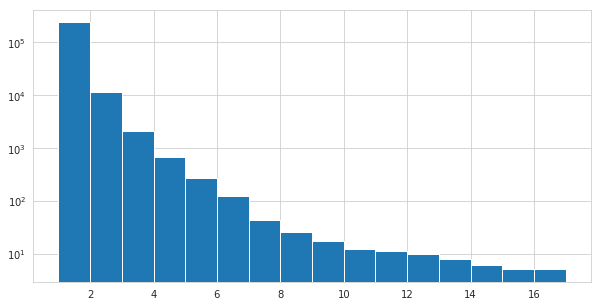

In [253]:
ax = buildings.version.hist(figsize=(10,5),bins=np.arange(1,buildings.version.max(),1))
ax.set_yscale('log')

### Most edited buildings?

In [254]:
buildings.sort_values(by='version', ascending=False).head()

,id,type,amenity,highway,building,name,length,area,aA,aD,aM,user,version,minorVersion,validSince,validUntil,changeset,center,date
1230887,297682282,way,parking,NaN,yes,1111 Lincoln Road,NaN,NaN,NaN,NaN,type-->multipolygon,thetornado76,18,0.0,1528432643,NaN,59654650,"-80.14088589999999,25.79084206",2018-06-08
1226092,297682282,way,parking,NaN,yes,1111 Lincoln Road,NaN,NaN,addr:city-->Miami Beach|-|addr:housenumber-->1...,NaN,NaN,lokejul,17,0.0,1526833732,1.528433e+09,59127373,"-80.14088589999999,25.79084206",2018-05-20
1222679,586957409,way,NaN,NaN,yes,Lighthouse for the Bind of the Palm Beaches,NaN,NaN,building:max_level-->1|-|building:min_level-->...,NaN,NaN,mrohret_aph,16,0.0,1526054280,NaN,58882780,"-80.08222846756757,26.754146110810805",2018-05-11
1223148,297682282,way,parking,NaN,yes,1111 Lincoln Road,NaN,NaN,NaN,NaN,NaN,lokejul,16,0.0,1526178705,1.526834e+09,58914572,"-80.14088589999999,25.79084206",2018-05-13
1027281,22341479,way,parking,NaN,yes,Flamingo Parking,NaN,NaN,NaN,NaN,NaN,carciofo,16,0.0,1512747881,NaN,54462180,"-80.27668777142857,25.794314600000003",2017-12-08


# Minor Versions?

In [256]:
df.minorVersion.value_counts()

0.0     932867
1.0      97401
2.0      18077
3.0       5070
4.0       1779
5.0        714
6.0        277
7.0         90
8.0         34
9.0         10
10.0         1
Name: minorVersion, dtype: int64

Text(0.5, 1.0, 'When Minor Versions Happen (Geometry Only Changes)')

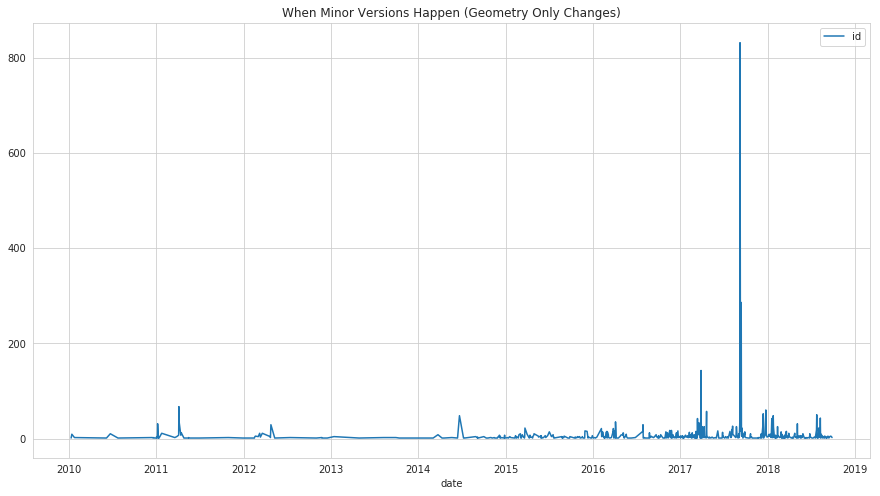

In [257]:
ax = buildings[buildings.minorVersion>0].groupby('date').aggregate({'id':'count'}).plot(figsize=(15,8));
ax.set_title("When Minor Versions Happen (Geometry Only Changes)")

# 10 Evolution of the Map: Roads --> Buildings?

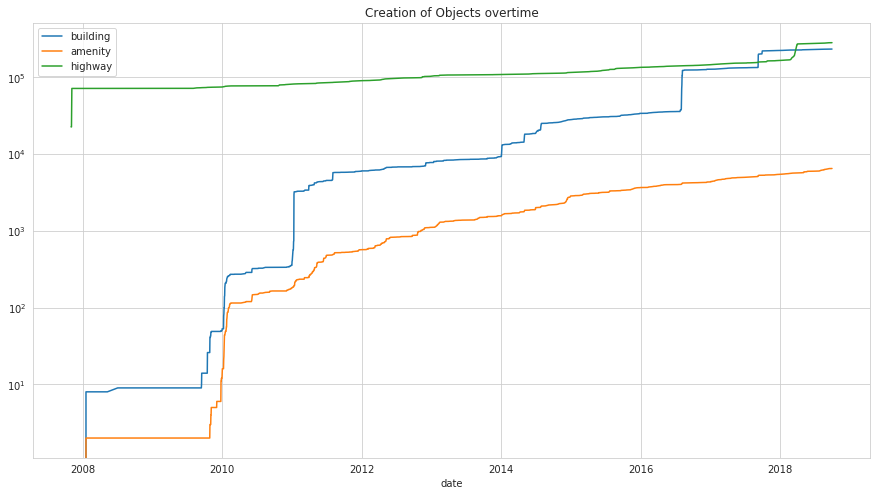

In [261]:
ax = df[(df.version==1) & (df.minorVersion==0)].groupby('date').aggregate({'building':'count','highway':'count','amenity':'count'}).cumsum().plot(figsize=(15,8))
ax.set_title('Creation of Objects overtime');
ax.set_yscale('LOG')

# Learning about Names

In [262]:
def extract_key(attributeString,attr):
    if type(attributeString)==str:
        try:
            tags   = attributeString.split("|-|")
            tuples = [x.split("-->") for x in tags]
            keys   = [x[0] for x in tuples]
            values = [x[1] for x in tuples]
            if attr in keys:
                return values[keys.index(attr)]
            else:
                return np.NaN
        except:
            print(attributeString)
            print("keys", keys)
            raise
    return np.NaN

In [263]:
df['nameAdded'] = df.aA.apply(lambda x: extract_key(x,'name'))

## When were names added to roads?

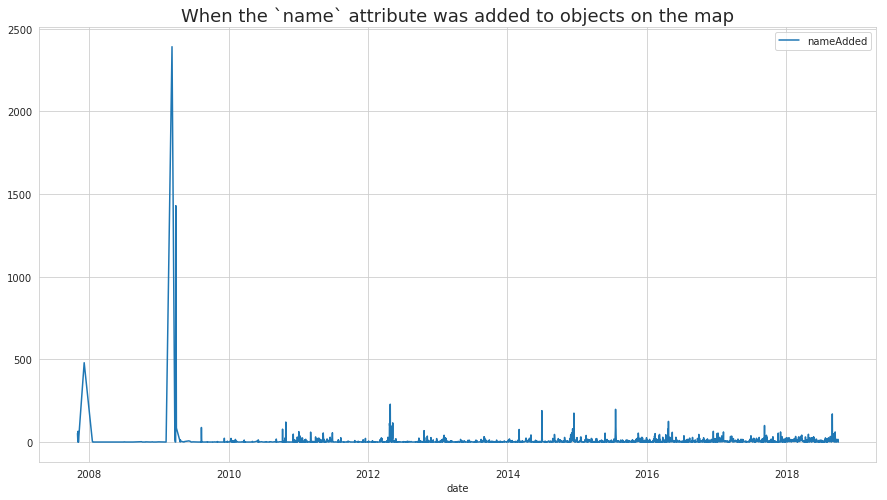

In [270]:
ax = df[pd.isnull(df.highway)].groupby('date').aggregate({'nameAdded':'count'}).plot(figsize=(15,8))
ax.set_title('When the `name` attribute was added to objects on the map',fontsize=18);

# Top 15 Mappers in Last month

In [271]:
df[df.date > datetime.date(2018,9,1)].groupby('user').aggregate({'id':'count'}).sort_values(by='id',ascending=False).head(15)


,id
user,
vvcat,1825
jlevente,654
biancah_telenav,648
carciofo,629
Ian Linder Sheldon,619
TheM3sseng3r,430
danuta_telenav,400
bogdanp_telenav,399
IsaacRay27,393


## A heatmap?

In [365]:
import json
featColl = {'type':'FeatureCollection','features':[]}
for date, edits in df[pd.notnull(df.building)].groupby('date'):
    try:
        geometryColl = edits.center.apply(lambda x: {'type':'Point','coordinates':[float(y) for y in x.split(",")]})
        geojson = {
            'geometry':{'type':'GeometryCollection','geometries':list(geometryColl)},
            'type':"Feature",
            'properties': {'days_since_2005': (date - datetime.date(2005,1,1) ).days, 'edits':len(edits)}
        }
        featColl['features'].append(geojson)
    except:
        print("err--moving on")
    
json.dump(featColl, open("/data/www/map/data/"+PLACE+".geojson",'w'))
print("\n\nCheck it out at: http://yetilabs.science/map?data=data/"+PLACE+".geojson")

err--moving on
err--moving on


Check it out at: http://yetilabs.science/map?data=data/haiti.geojson


In [331]:
len(df[pd.notnull(df.building)])

1533

In [332]:
df.head()

,id,type,amenity,highway,building,name,length,area,aA,aD,aM,user,version,minorVersion,validSince,validUntil,changeset,center,date
0,30339672,node,NaN,traffic_signals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bit,1,NaN,1181797472,1.213573e+09,96095,"-99.1531479,19.3802141",2007-06-14
1,30339694,node,NaN,traffic_signals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bit,1,NaN,1181797519,1.212600e+09,96095,"-99.1502125,19.4039843",2007-06-14
2,30339776,node,NaN,traffic_signals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bit,1,NaN,1181797664,1.212600e+09,96095,"-99.1400845,19.4035957",2007-06-14
3,30339774,node,NaN,traffic_signals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bit,1,NaN,1181797664,1.212600e+09,96095,"-99.1426938,19.4036929",2007-06-14
4,30340092,node,NaN,traffic_signals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bit,1,NaN,1181797918,1.281690e+09,96095,"-99.1512854,19.3799064",2007-06-14


In [359]:
df.head()

,id,type,amenity,highway,building,name,length,area,aA,aD,aM,user,version,minorVersion,validSince,validUntil,changeset,center,date
0,22871332,way,NaN,NaN,NaN,NaN,3.056892,3.056892,aeroway-->runway|-|created_by-->Potlatch 0.7,NaN,NaN,dcjc,1,0.0,1202173954,1.202174e+09,42286,"-72.29258585,18.58",2008-02-05
1,22871332,way,NaN,NaN,NaN,NaN,3.056892,3.056892,NaN,NaN,NaN,dcjc,2,0.0,1202173990,1.208630e+09,42286,"-72.29258585,18.58",2008-02-05
2,22894188,way,NaN,NaN,NaN,NaN,21.690420,21.690420,natural-->coastline|-|created_by-->JOSM,NaN,NaN,Elwood,1,0.0,1202379607,1.263630e+09,66600,"-72.99267687451922,18.805359617628206",2008-02-07
3,246632901,node,NaN,NaN,NaN,Pointe du Cul de Sac,NaN,NaN,created_by-->JOSM,NaN,NaN,Elwood,1,NaN,1202477170,1.263414e+09,71288,"-72.3586656,18.6299745",2008-02-08
4,22907271,way,NaN,NaN,NaN,NaN,3.514085,3.514085,natural-->coastline|-|created_by-->JOSM,NaN,NaN,Elwood,1,0.0,1202477450,1.263489e+09,71288,"-72.38109391860465,18.69599364883721",2008-02-08
